# Statistics of the models

- Parameters
- Floating point operations (FLOPs)
  - Feedforward layers: $FLOPs = 2 * input\_size * output\_size$
  - Convolutional layers: $FLOPs = 2 * out\_w * out\_h * in\_channels * kernel\_size^2 * output\_channels$

## 1. Import & Definations

In [1]:
import os
import sys
from typing import Tuple, Union

ROOT_DIR = os.path.dirname(os.path.abspath(""))
sys.path.append(ROOT_DIR)

import thop
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from numpy.typing import NDArray

from mpfilter.model import MpAE, MpVCNN, MpCNN1D
from mpfilter.config import ConfigAE, ConfigCNN1D, ConfigVCNN
from mpfilter.inferer import InferAE, InferVCNN, InferClsBase

pltconfig = {
    "axes.unicode_minus": False,
    "font.sans-serif": ["Times New Roman"],
    "font.weight": "bold",
    "font.size": 14,
    "mathtext.fontset": "stix",
}
plt.rcParams.update(pltconfig)

conf_ae = ConfigAE(f"{ROOT_DIR}/config/config_ae.json", init=False)
conf_vcnn = ConfigVCNN(f"{ROOT_DIR}/config/config_vcnn.json", init=False)
conf_cnn1d = ConfigCNN1D(f"{ROOT_DIR}/config/config_cnn1d.json", init=False)

model_ae_torch = MpAE(
    in_features=conf_ae.in_features,
    out_features=conf_ae.out_features,
    hid_features=conf_ae.hid_features,
)
model_vcnn_torch = MpVCNN(
    in_features=conf_vcnn.in_features,
    out_features=conf_vcnn.out_features,
)
model_cnn1d_torch = MpCNN1D(
    in_features=conf_cnn1d.in_features,
    out_features=conf_cnn1d.num_class,
)

inferer_ae = InferAE("models/AE_0.onnx")
inferer_vcnn = InferVCNN("models/VCNN_0.onnx")
inferer_cnn1d_ds02 = InferClsBase("models/CNN1D_0_DS02.onnx")
inferer_cnn1d_dsall = InferClsBase("models/CNN1D_0_DSALL.onnx")
inferer_dt_ds02 = InferClsBase("models/DT_0_DS02.onnx")
inferer_dt_dsall = InferClsBase("models/DT_0_DSALL.onnx")
inferer_rf_ds02 = InferClsBase("models/RF_0_DS02.onnx")
inferer_rf_dsall = InferClsBase("models/RF_0_DSALL.onnx")
inferer_lsvm_ds02 = InferClsBase("models/LSVM_0_DS02.onnx")
inferer_lsvm_dsall = InferClsBase("models/LSVM_0_DSALL.onnx")

# Model, #Params, #MACs, #FLOPs
statistics = []

In [2]:
def minmax(x: NDArray[np.float32]) -> NDArray[np.float32]:
    return (x - x.min()) / (x.max() - x.min())

def interpolate(
    xp: NDArray[np.float32],
    fp: NDArray[np.float32],
    x: Union[NDArray[np.float32], None] = None,
    left: float = 0,
    right: float = 0,
) -> Tuple[NDArray[np.float32], NDArray[np.float32]]:
    assert xp.size == fp.size
    xp = np.sort(xp)
    # x should be 2D (B, N)
    # minmax
    fp1 = minmax(fp)
    # interpolate
    x = x or np.arange(400, 4000, 1, dtype=np.float32)
    yy = np.interp(x, xp, fp1, left=left, right=right)
    return (x, yy.astype(np.float32))

## 2. Model #Params and #FLOPs

In [3]:
x = torch.randn(1, 3600)
macs, params = thop.profile(model_ae_torch, inputs=(x,)) # type: ignore
macs, params, flops = thop.clever_format([macs, params, macs*2], "%.2f")
statistics.append(["AE", params, macs, flops])

x = torch.randn(1, 1, 3600)
macs, params = thop.profile(model_vcnn_torch, inputs=(x,))  # type: ignore
macs, params, flops = thop.clever_format([macs, params, macs*2], "%.2f")
statistics.append(["VCNN", params, macs, flops])


[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [4]:
x = torch.randn(1, 1, 3600)
macs, params = thop.profile(model_cnn1d_torch, inputs=(x,))  # type: ignore
macs, params, flops = thop.clever_format([macs, params, macs*2], "%.2f")
statistics.append(["CNN1D", params, macs, flops])


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [5]:
# /1000_1000 means M
len_dt_ds02    = len(open("models/DT_0_DS02.onnx"   , "rb").read())/1000_000
len_dt_dsall   = len(open("models/DT_0_DSALL.onnx"  , "rb").read())/1000_000
len_rf_ds02    = len(open("models/RF_0_DS02.onnx"   , "rb").read())/1000_000
len_rf_dsall   = len(open("models/RF_0_DSALL.onnx"  , "rb").read())/1000_000
len_lsvm_ds02  = len(open("models/LSVM_0_DS02.onnx" , "rb").read())/1000_000
len_lsvm_dsall = len(open("models/LSVM_0_DSALL.onnx", "rb").read())/1000_000

statistics.extend(
    [
        ["DT+DS02",    f"{len_dt_ds02:.2f}M", "-", "-"],
        ["DT+DSALL",   f"{len_dt_dsall:.2f}M", "-", "-"],
        ["RF+DS02",    f"{len_rf_ds02:.2f}M", "-", "-"],
        ["RF+DSALL",   f"{len_rf_dsall:.2f}M", "-", "-"],
        ["LSVM+DS02",  f"{len_lsvm_ds02:.2f}M", "-", "-"],
        ["LSVM+DSALL", f"{len_lsvm_dsall:.2f}M", "-", "-"],
    ]
)

In [6]:
df = pd.DataFrame(statistics, columns=["Model", "#Params", "#MACs", "#FLOPs"])
df

,Model,#Params,#MACs,#FLOPs
0,AE,20.33M,20.32M,40.63M
1,VCNN,20.25M,136.44M,272.88M
2,CNN1D,4.02M,6.36M,12.71M
3,DT+DS02,0.19M,-,-
4,DT+DSALL,0.29M,-,-
5,RF+DS02,16.87M,-,-
6,RF+DSALL,25.94M,-,-
7,LSVM+DS02,0.45M,-,-
8,LSVM+DSALL,0.45M,-,-


## 3. Inference Benchmarking

In [7]:
import time
from tqdm import tqdm


N = 1000
R = 10
inferer_all = [
    ["AE", inferer_ae],
    ["VCNN", inferer_vcnn],
    ["CNN1D+DS02", inferer_cnn1d_ds02],
    ["CNN1D+DSALL", inferer_cnn1d_dsall],
    ["DT+DS02", inferer_dt_ds02],
    ["DT+DSALL", inferer_dt_dsall],
    ["RF+DS02", inferer_rf_ds02],
    ["RF+DSALL", inferer_rf_dsall],
    ["LSVM+DS02", inferer_lsvm_ds02],
    ["LSVM+DSALL", inferer_lsvm_dsall],
]

# Model, batch_size, mean, std, per sample
results_all = []
ds_mpc_mpb = pd.read_feather(f"{ROOT_DIR}/data/ds_mpc_mpb_24.ftr")
names = ds_mpc_mpb["name"].unique()
for batch_size in [1, 8, 16, 32, 64, 128]:
    batch_yy = []
    for i in range(len(names)):
        if i >= 1 and i % batch_size == 0:
            break
        x = ds_mpc_mpb[ds_mpc_mpb["name"] == names[i]]["wavenum"]
        y = ds_mpc_mpb[ds_mpc_mpb["name"] == names[i]]["intensity"]
        xx, yy = interpolate(x, y, left=0, right=0)
        batch_yy.append(yy)

    # inference
    inputs = np.vstack(batch_yy)

    for inferer in tqdm(inferer_all):
        for r in range(R):
            for n in range(N):
                start = time.time_ns()
                inferer[1](inputs)
                stop = time.time_ns()
                interval = stop - start
                results_all.append([inferer[0], batch_size, interval])

100%|██████████| 10/10 [22:29<00:00, 135.00s/it] 


In [8]:
benchmark_all_df = pd.DataFrame(results_all, columns=["Model", "batch size", "time"])
benchmark_all_df["time"] = benchmark_all_df["time"] / 1e3 # ns -> us
benchmark_all_df.to_csv("benchmark.csv", index=False)
benchmark_all_df.head()

,Model,batch size,time
0,AE,1,3600.513
1,AE,1,2265.279
2,AE,1,1942.820
3,AE,1,1819.851
4,AE,1,1500.413


## 4. Plot Figures

In [9]:
benchmark_all_df = pd.read_csv("benchmark.csv")

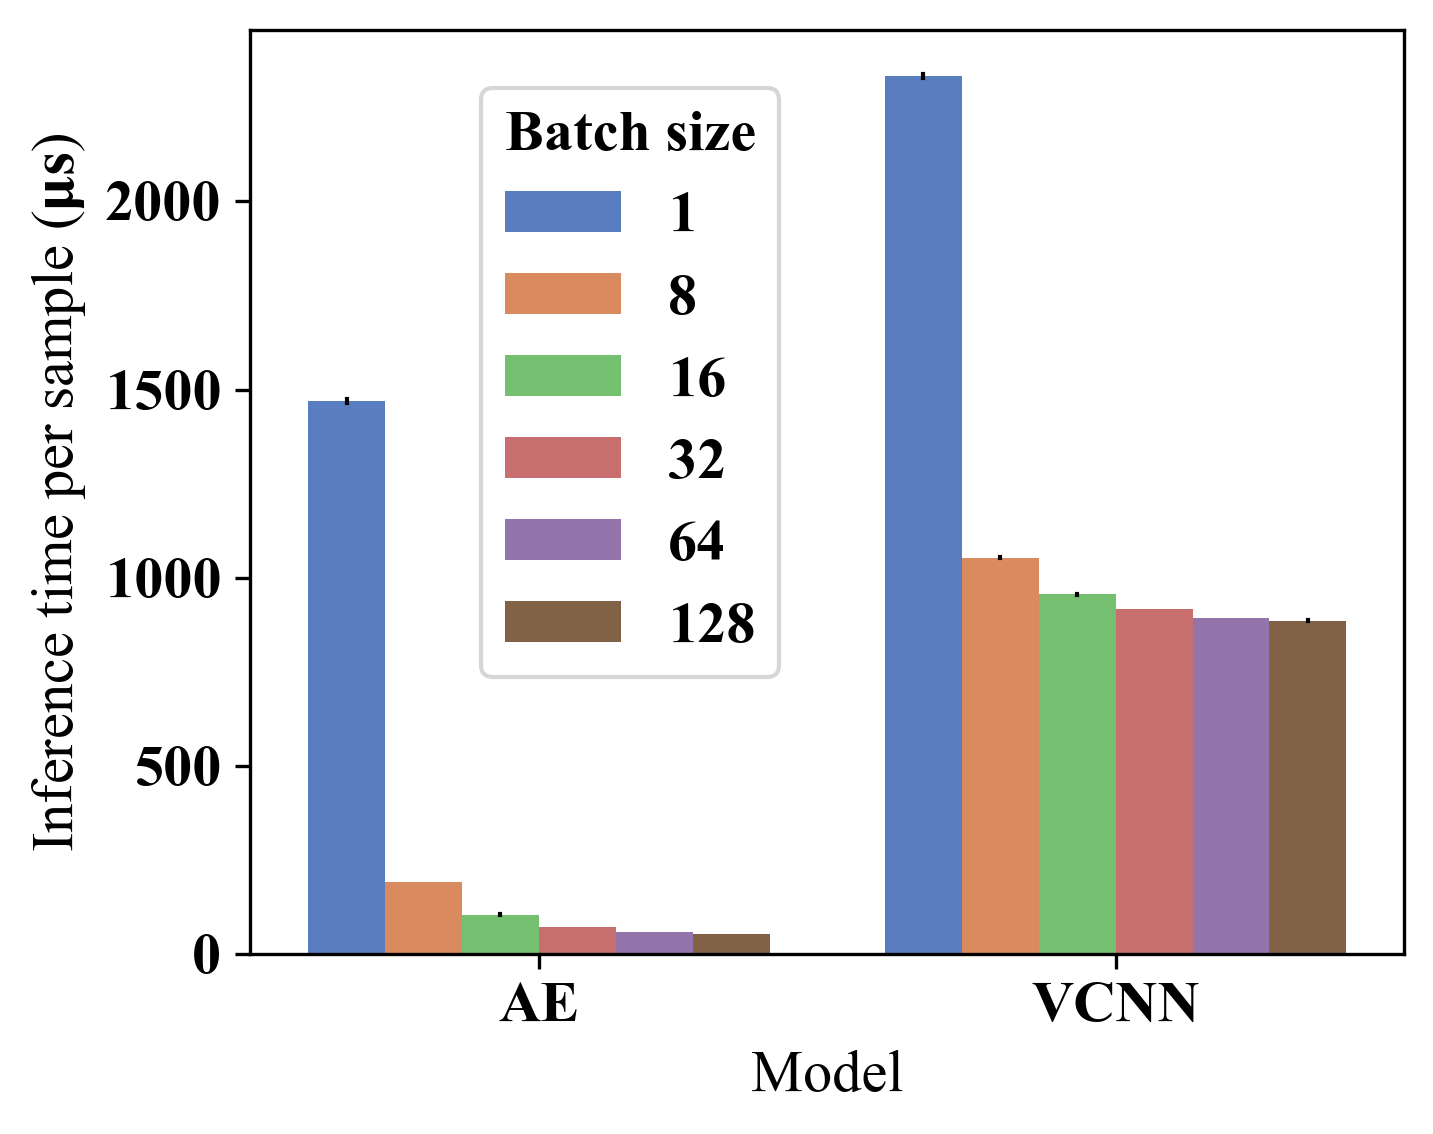

In [29]:

import seaborn as sns
import matplotlib.pyplot as plt

df = benchmark_all_df.copy(deep=True)
df = df[df["Model"].isin(["AE", "VCNN"])]
df["time"] = df["time"] / df["batch size"] # per sample

fig = plt.figure(figsize=(5, 4), dpi=300)
ax = fig.add_subplot(111)
pallette = sns.color_palette("muted", len(df["batch size"].unique()))
# sns.stripplot(
#     x="Model",
#     y="time",
#     alpha=0.5,
#     marker="o",
#     palette=pallette,
#     edgecolor="black",
#     linewidth=0,
#     jitter=0.2,
#     data=df,
#     hue="batch size",
#     ax=ax,
# )

# sns.boxplot(
#     x="Model",
#     y="time",
#     palette=pallette,
#     hue="batch size",
#     fliersize=0.5,
#     linewidth=1,
#     data=df,
#     ax=ax,
# )


# the above plots are hard to explain...
sns.barplot(
    df,
    x="Model",
    y="time",
    estimator=np.mean,
    palette=pallette,
    errorbar=("ci", 95),
    hue="batch size",
    err_kws={"linewidth": 1, "color": "black"},
    ax=ax,
)
ax.legend(loc=(0.2, 0.3), title="Batch size")
ax.set_xlabel("Model")
ax.set_ylabel(r"Inference time per sample ($\mathrm{\mu s}$)")
fig.tight_layout()
fig.savefig("figs/benchmark_ae_vcnn.png", dpi=400, bbox_inches="tight")
plt.show()

In [11]:
benchmark_mean_sd = (
    benchmark_all_df
    .groupby(["Model", "batch size"])
    .agg(["mean", "std"])
)
benchmark_mean_sd.columns = benchmark_mean_sd.columns.droplevel(0)
benchmark_mean_sd["mean±sd"] = benchmark_mean_sd.apply(lambda x: f"{x['mean']:.2f}±{x['std']:.2f} μs", axis=1)
benchmark_mean_sd.to_csv("benchmark_mean_sd.csv")
benchmark_mean_sd = pd.read_csv("benchmark_mean_sd.csv")
benchmark_mean_sd["per sample"] = benchmark_mean_sd["mean"] / benchmark_mean_sd["batch size"]
benchmark_mean_sd.to_csv("benchmark_mean_sd.csv")
benchmark_mean_sd.head()

,Model,batch size,mean,std,mean±sd,per sample
0,AE,1,1468.521317,266.961370,1468.52±266.96 μs,1468.521317
1,AE,8,1539.552813,200.336555,1539.55±200.34 μs,192.444102
2,AE,16,1681.646324,231.125337,1681.65±231.13 μs,105.102895
3,AE,32,2303.659856,320.838571,2303.66±320.84 μs,71.989371
4,AE,64,3702.035413,335.035656,3702.04±335.04 μs,57.844303


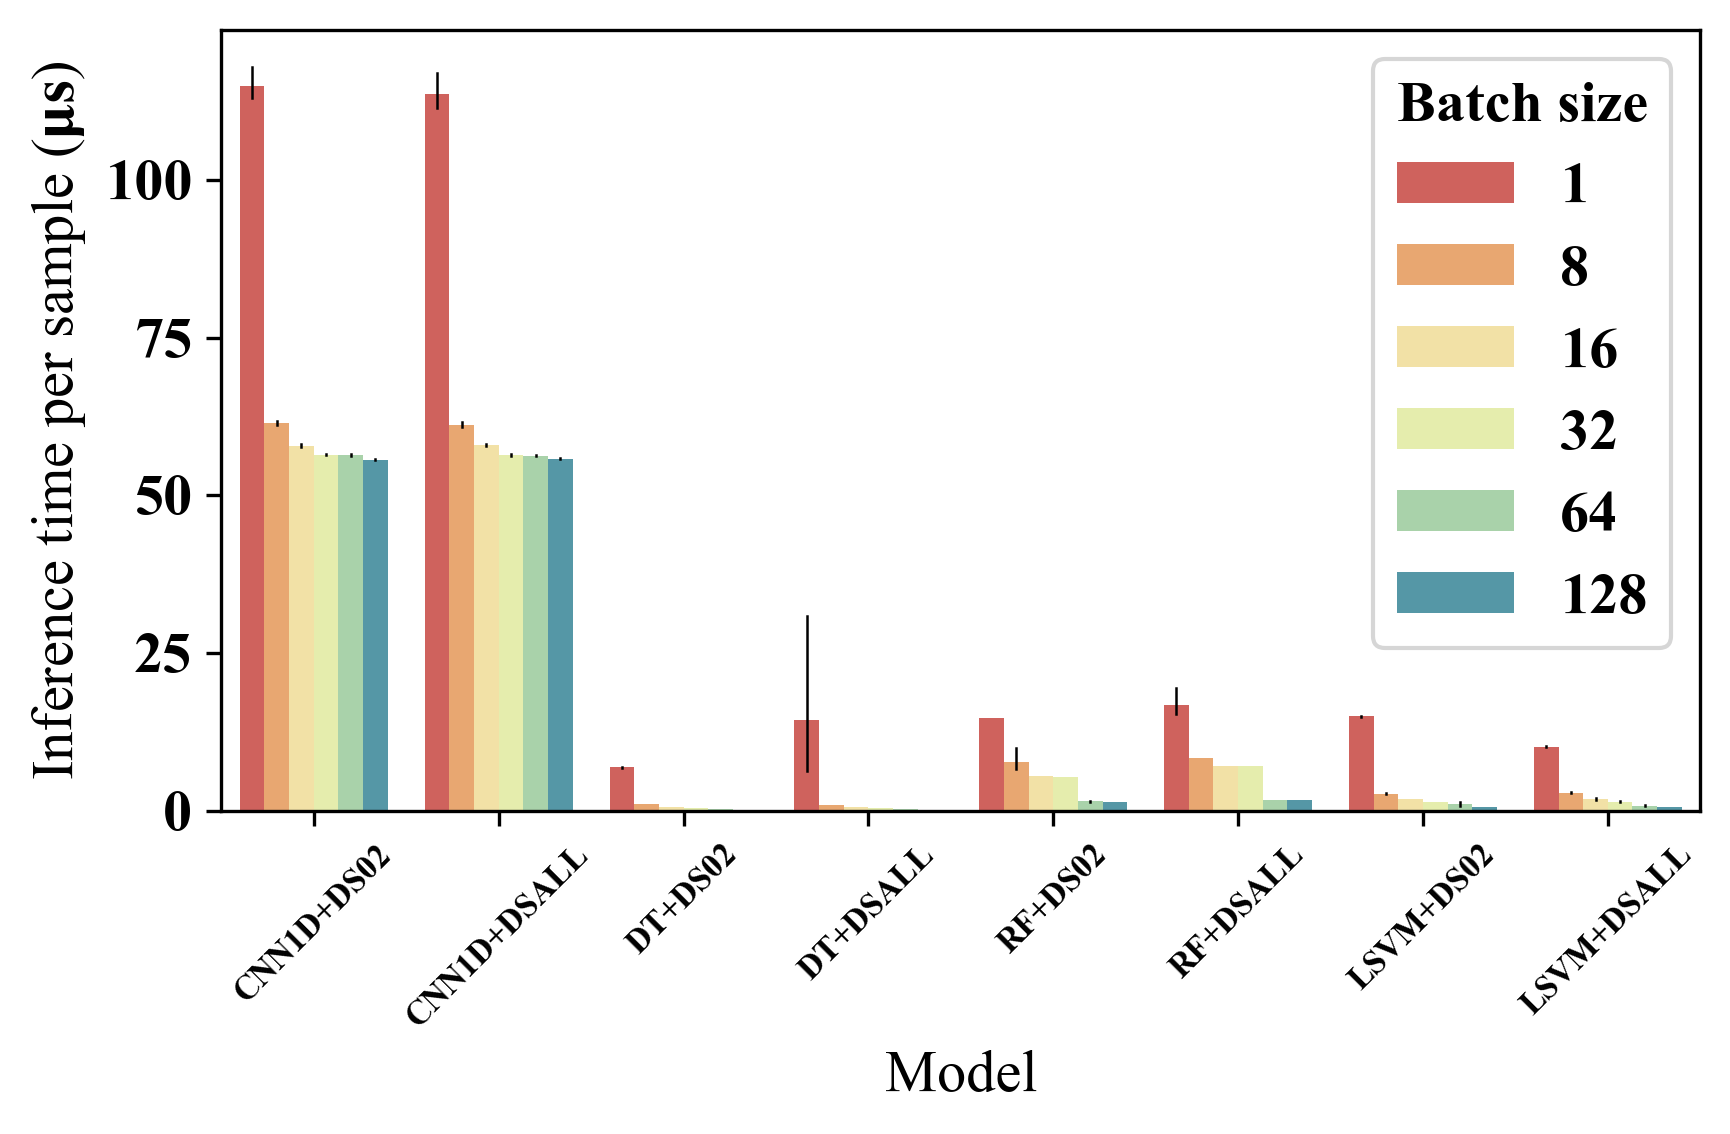

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

df = benchmark_all_df.copy(deep=True)
df = df[~df["Model"].isin(["AE", "VCNN"])]
df["time"] = df["time"] / df["batch size"] # per sample
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = fig.add_subplot(111)
pallette = sns.color_palette("Spectral", n_colors=len(df["batch size"].unique()))
sns.barplot(
    df,
    x="Model",
    y="time",
    estimator=np.mean,
    palette=pallette,
    errorbar=("ci", 95),
    hue="batch size",
    err_kws={"linewidth": 0.6, "color": "black"},
    ax=ax,
)
ax.tick_params(axis="x", which="major", labelsize=8, rotation=45)
ax.legend(loc="upper right", title="Batch size")
ax.set_xlabel("Model")
ax.set_ylabel(r"Inference time per sample ($\mathrm{\mu s}$)")
fig.tight_layout()
plt.savefig("figs/benchmark_classification.png", dpi=400, bbox_inches="tight")
plt.show()